# Georcoronal Correction


In [2]:
# import
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

## Data

In [3]:
file_path = 'ascii/J14301603+2303445_2023-01-06_COS.dat'

t = Table.read(file_path, format='ascii', delimiter='\s', header_start=3, data_start=5)

column_names = ['Wavelength', 'F_lambda', 'e_F_lambda']

original_colnames = t.colnames

for original, new in zip(original_colnames, column_names):
    t.rename_column(original, new)
    
t.sort('Wavelength')

In [4]:
hdr_file_path = 'ascii/J14301603+2303445_2023-01-06_COS_info.hdr'

with open(hdr_file_path, 'r') as file:
    for line in file:
        print(line.strip())


SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                    8 / array data type
NAXIS   =                    0 / number of array dimensions
EXTEND  =                    T
NEXTEND =                    1 / Number of standard extensions
DATE    = '2023-01-07'         / date this file was written (yyyy-mm-dd)
FILENAME= 'lf0a01010_x1dsum.fits' / name of file
FILETYPE= 'SCI      '          / type of data found in data file

TELESCOP= 'HST'                / telescope used to acquire data
INSTRUME= 'COS   '             / identifier for instrument used to acquire data
EQUINOX =               2000.0 / equinox of celestial coord. system

/ DATA DESCRIPTION KEYWORDS

ROOTNAME= 'lf0a01awq                         ' / rootname of the observation set
IMAGETYP= 'TIME-TAG          ' / type of exposure identifier
PRIMESI = 'COS   '             / instrument designated as prime

/ TARGET INFORMATION

TARGNAME= '2MASS-J14301603+2303445        ' / proposer's target name
RA_TARG = 

## Find the width of the lines in pixels and Angstroms.


## Projected Aperture Calculation

### Given Data
- **Aperture PSA width:** 0.2 arcseconds
- **COS Platescale:** 23.0 milliarcseconds/pixel = 0.023 arcseconds/pixel
- **Grating G140L Average Dispersion:** 0.6 Angstroms/pixel
- **Central Wavelength:** 800 Angstrom
- **Lifetime Position:** 3

### Calculation
1. **Calculate the projected aperture width in pixels:**

   $$
   \text{Projected aperture width (pixels)} = \frac{0.2 \text{ arcseconds}}{0.023 \text{ arcseconds per pixel}} = 8.7 \text{ pixels}
   $$

2. **Calculate the projected aperture width in Angstroms:**

   $$
   \text{Projected aperture width (Angstroms)} = 8.7 \text{ pixels} \times 0.6 \text{ Angstroms per pixel} = 5.22 \text{ Angstroms}
   $$



## Creating box profile in spctrum

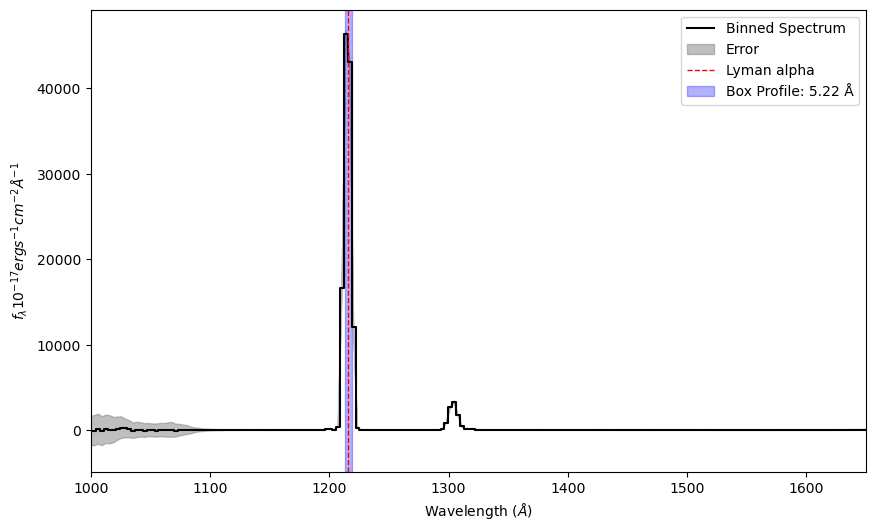

In [5]:
# Binning the data
z = 0.081

bin_width = 3
bins = np.arange(min(t["Wavelength"]), max(t["Wavelength"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["Wavelength"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["Wavelength"][in_bin]))
        binned_flux.append(np.mean(t["F_lambda"][in_bin]))
        binned_flux_err.append(np.mean(t["e_F_lambda"][in_bin]))

binned_wl = np.array(binned_wl)*(1+z)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

# Plotting the binned spectrum
plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")

# Projected Aperture Calculation
aperture_width_arcseconds = 0.2
cos_platescale_arcseconds_per_pixel = 0.023
grating_dispersion_angstroms_per_pixel = 0.6

# Calculate the projected aperture width in pixels
projected_aperture_width_pixels = aperture_width_arcseconds / cos_platescale_arcseconds_per_pixel

# Calculating the projected aperture width in Angstroms
projected_aperture_width_angstroms = projected_aperture_width_pixels * grating_dispersion_angstroms_per_pixel

# Box profile dimensions
central_wavelength = 1216
half_box_width_angstroms = projected_aperture_width_angstroms / 2

# Plot the box profile
plt.axvspan(central_wavelength - half_box_width_angstroms, central_wavelength + half_box_width_angstroms,
            color='blue', alpha=0.3, label=f'Box Profile: {projected_aperture_width_angstroms:.2f} Å')

plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1000, 1650)
#plt.ylim(-100, 400)
plt.legend()
plt.show()

# COS Line Spread Function (LSF)

Copied a lot of codes from the following: https://github.com/spacetelescope/notebooks/blob/master/notebooks/COS/LSF/LSF.ipynb

In [5]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import functional_models
from astropy.convolution import convolve
from astroquery.mast import Observations
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import urllib
import tarfile
from pathlib import Path

#### Defining directories where files will be saved

In [115]:
# These will be important directories for the Notebook

cwd = Path(".")
datadir = "C:/Users/serat/Downloads/AGN/data/"
outputdir = cwd / "output"
plotsdir = cwd / "output" / "plots"

# Make the directories if they don't exist
#datadir.mkdir(exist_ok=True), outputdir.mkdir(exist_ok=True), plotsdir.mkdir(exist_ok=True)

#### Downloading the data files

In [7]:
# Search for obs_id of files, generate data product list
pl = Observations.get_product_list(
    Observations.query_criteria(obs_id="LF0A01010")
)  

download = Observations.download_products(
    pl[pl["productSubGroupDescription"] == "X1DSUM"],  # filter and download searched files
    download_dir=str(datadir),
)

# Give the program the path to your downloaded data
fuvFile = download["Local Path"][0]

INFO: Found cached file data\mastDownload\HST\lf0a01010\lf0a01010_x1dsum.fits with expected size 933120. [astroquery.query]


#### Getting info from the header of the downloaded files

In [8]:
fuvHeader0 = fits.getheader(fuvFile, ext=0)  # Select the primary header
print(f"For the file {fuvFile}, the relevant parameters are: ")
param_dict = {}  # Make a dict to store what you find here

for hdrKeyword in [
    "DETECTOR",
    "OPT_ELEM",
    "LIFE_ADJ",
    "CENWAVE",
    "DISPTAB",
]:  # Print out the relevant values
    try:  # For DISPTAB
        value = fuvHeader0[hdrKeyword].split("$")[1]  # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value                # DISPTAB needs the split here
    except:  # For other params
        value = fuvHeader0[hdrKeyword]  # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value
    print(f"{hdrKeyword} = {value}")  # Print the key/value pairs

For the file data\mastDownload\HST\lf0a01010\lf0a01010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G140L
LIFE_ADJ = 3
CENWAVE = 800
DISPTAB = 5b919205l_disp.fits


#### Downloading the LSF file for the specific setup that was used

In [9]:
def fetch_files(det, grating, lpPos, cenwave, disptab):
    """
    Given all the inputs: (detector, grating, LP-POS, cenwave, dispersion table,) this will download both
    the LSF file and Disptab file you should use in the convolution and return their paths.
    Returns:
    LSF_file_name (str): filename of the new downloaded LSF file
    disptab_path (str): path to the new downloaded disptab file
    """
    COS_site_rootname = (
        "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"
        "performance/spectral-resolution/_documents/"
    )  # Link to where all the files live - split into 2 lines
    if det == "NUV":  # Only one file for NUV
        LSF_file_name = "nuv_model_lsf.dat"
    elif det == "FUV":  # FUV files follow a naming pattern
        LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP4_cn.dat"

    LSF_file_webpath = COS_site_rootname + LSF_file_name  # Where to find file online
    urllib.request.urlretrieve(
        LSF_file_webpath, str(datadir / LSF_file_name)
    )  # Where to save file to locally
    print(f"Downloaded LSF file to {str(datadir/ LSF_file_name)}")

    # And we'll need to get the DISPTAB file as well
    disptab_path = str(datadir / disptab)
    urllib.request.urlretrieve(
        f"https://hst-crds.stsci.edu/unchecked_get/references/hst/{disptab}",
        disptab_path,
    )
    print(f"Downloaded DISPTAB file to {disptab_path}")

    return LSF_file_name, disptab_path

In [12]:
# We'll pass that fetch function the parameters we determined earlier
# This "unpacked argument" phrasing works because of the order in which we added the params to the dict
LSF_file_name, disptab_path = fetch_files(*list(param_dict.values()))

Downloaded LSF file to data\aa_LSFTable_G140L_800_LP4_cn.dat
Downloaded DISPTAB file to data\5b919205l_disp.fits


In [13]:
print(LSF_file_name, disptab_path)

aa_LSFTable_G140L_800_LP4_cn.dat data\5b919205l_disp.fits


#### Reading the LSF file

In [14]:
def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    if "nuv_" in filename:  # If its an NUV file, header starts 1 line later
        ftype = "nuv"

    else:  # assume its an FUV file
        ftype = "fuv"
    hs = 0
    lsf = Table.read(filename, format="ascii", header_start=hs)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2  # integer division to yield whole pixels

    # the column names returned as integers.
    lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

In [15]:
lsf, pix, lsf_wvlns = read_lsf(str(datadir / LSF_file_name))
lsf[lsf.colnames[:5]]

780,785,790,795,800
float64,float64,float64,float64,float64
4.692724547628632e-06,4.718953659063335e-06,4.532569539262592e-06,4.56506253266115e-06,4.608972042497935e-06
4.750364399525683e-06,4.796407366039756e-06,4.5947534197434e-06,4.642075309576548e-06,4.6790610242571955e-06
4.804300570884076e-06,4.853719549355936e-06,4.684395061417897e-06,4.733885240126606e-06,4.758198141682205e-06
4.850583245010395e-06,4.883991026167599e-06,4.787618753854359e-06,4.822279626189361e-06,4.831348554596604e-06
4.894847674428513e-06,4.905464874387156e-06,4.8837693642126036e-06,4.890457185768141e-06,4.892970211297972e-06
4.9422562293826645e-06,4.937175872158721e-06,4.956465765816269e-06,4.93202361057307e-06,4.945550940693758e-06
4.9957160596937465e-06,4.990183749074244e-06,5.005503814689938e-06,4.961050730531378e-06,4.997319490574063e-06
5.053717934802756e-06,5.060738946257661e-06,5.0462070941289216e-06,4.998572847807593e-06,5.050301621020904e-06
5.11219558864638e-06,5.1325239187029655e-06,5.09205841986308e-06,5.049758726184797e-06,5.096844314889047e-06


#### Plotting the LSF kernel sampled

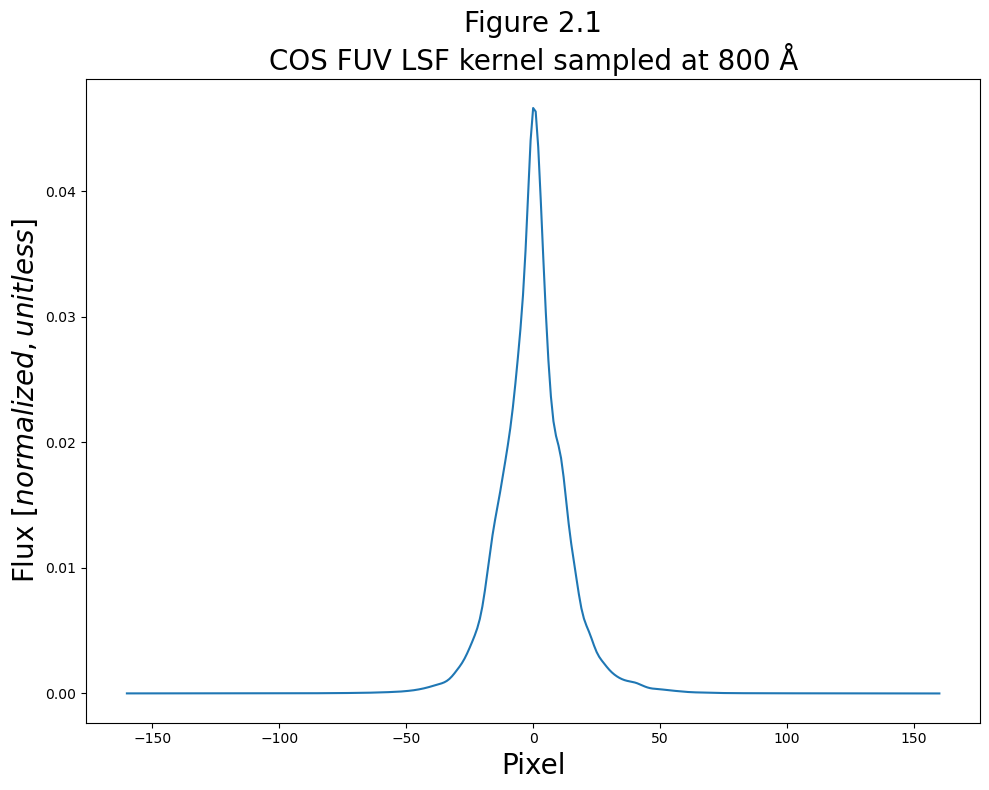

In [16]:
# Set up the figure
plt.figure(figsize=(10, 8))
# Fill the figure with a plot of the data
plt.plot(pix, lsf["800"])
# Give figure the title and labels
plt.title("Figure 2.1\nCOS FUV LSF kernel sampled at 800 Å", size=20)
plt.xlabel("Pixel", size=20)
plt.ylabel("Flux [$normalized,unitless$]", size=20)
# format and save the figure
plt.tight_layout()
plt.savefig(str(plotsdir / "oneKernel.png"), bbox_inches="tight")

#### Plotting LSF kernel for different wavelengths

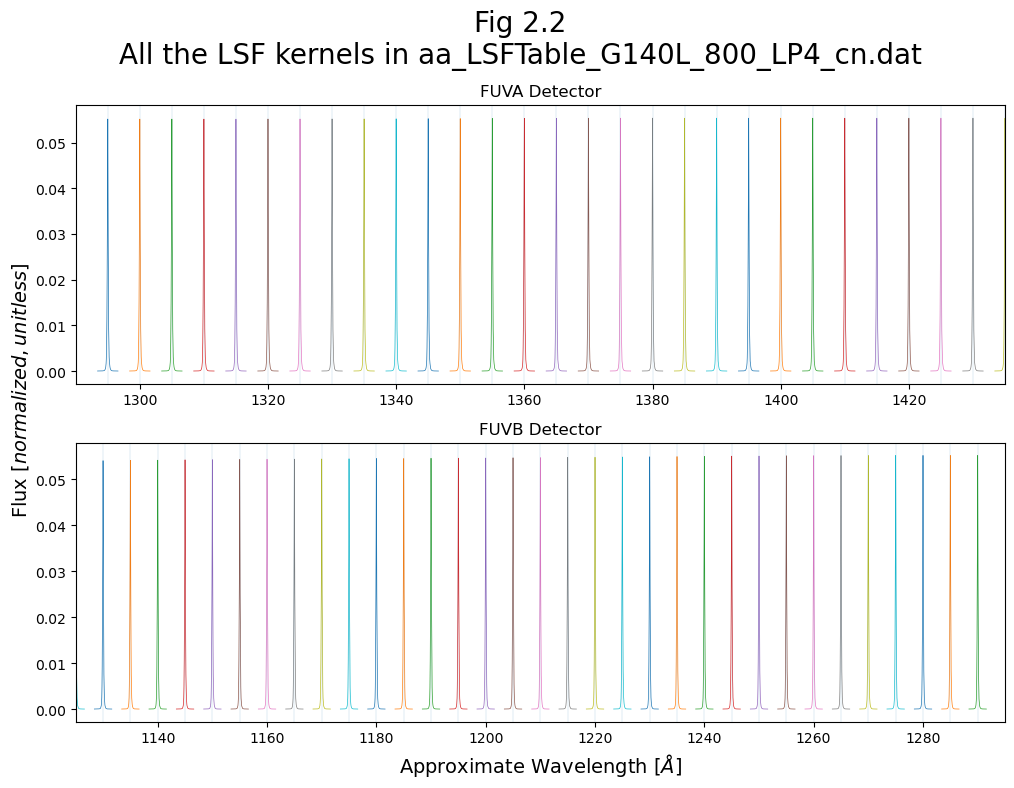

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)

# Loop through the lsf kernels
for i, col in enumerate(lsf.colnames):
    line_wvln = int(col)  # central position
    contents = lsf[col].data  # actual shape

    if line_wvln < 1291:  # split into the FUVB segment
        xrange = 0.00997 * pix + line_wvln  # ROUGHLY convert pix to wvln
        ax1.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax1.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

    elif line_wvln > 1291:  # split into the FUVA segment
        xrange = 0.00997 * pix + line_wvln  # ROUGHLY convert pix to wvln
        ax0.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax0.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

# Format the figure
ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)
# Add labels, titles and text
fig.suptitle(f"Fig 2.2\nAll the LSF kernels in {LSF_file_name}", fontsize=20)
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax1.set_xlabel("Approximate Wavelength [$\AA$]", size=14)
fig.text(s="Flux [$normalized,unitless$]", x=-0.01, y=0.35, rotation="vertical", size=14)
plt.tight_layout()

# Save the figure
plt.savefig(str(plotsdir / "allKernels.png"), bbox_inches="tight")

#### Getting Dispersion parameters

In [18]:
def get_disp_params(disptab, cenwave, segment, x=[]):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant\
    dispersion relationship/wavelength solution over input pixels.
    Parameters:
    disptab (str): Path to your DISPTAB file.
    cenwave (str): Cenwave for calculation of dispersion relationship.
    segment (str): FUVA or FUVB?
    x (list): Range in pixels over which to calculate wvln with dispersion relationship (optional).
    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab) as d:
        wh_disp = np.where(
            (d[1].data["cenwave"] == cenwave)
            & (d[1].data["segment"] == segment)
            & (d[1].data["aperture"] == "PSA")
        )[0]
        disp_coeff = d[1].data[wh_disp]["COEFF"][0] # 0 is needed as this returns nested list [[arr]]
        d_tv03 = d[1].data[wh_disp]["D_TV03"]  # Offset from WCA to PSA in Thermal Vac. 2003 data
        d_orbit = d[1].data[wh_disp]["D"]  # Current offset from WCA to PSA

    delta_d = d_tv03 - d_orbit

    if len(x):  # If given a pixel range, build up a polynomial wvln solution pix -> λ
        wavelength = np.polyval(p=disp_coeff[::-1], x=np.arange(16384))
        return disp_coeff, wavelength
    else:  # If x is empty:
        return disp_coeff

#### Redefining the LSF

In [19]:
def redefine_lsf(lsf_file, cenwave, disptab, detector="FUV"):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    detector (str): FUV or NUV?
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    if detector == "FUV":
        xfull = np.arange(16384)

        # Read in the dispersion relationship here for the segments
        ### FUVA is simple
        disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, "FUVA", x=xfull)
        ### FUVB isn't taken for cenwave 1105, nor 800:
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff_b, wavelength_b = get_disp_params(
                disptab, cenwave, "FUVB", x=xfull)
        elif cenwave == 1105:
            # 1105 doesn't have an FUVB so set it to something arbitrary and clearly not real:
            wavelength_b = [-99.0, 0.0]

        # Get the step size info from the FUVA 1st order dispersion coefficient
        step = disp_coeff_a[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        lsf_array = [np.array(lsf[key]) for key in lsf.keys()]
        if (deltaw < len(pix) * step * 2):  # resamples if the spacing of the original LSF wvlns is too narrow
            # this is all a set up of the bins we want to use
            # The wvln difference between kernels of the new LSF should be about twice their width
            new_deltaw = round(len(pix) * step * 2.0)  
            new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
            new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns

            # populating the lsf with the proper bins
            new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate
            for i, current_w in enumerate(new_w):
                dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
                lsf_index = np.argmin(dist)
                orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
                new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
        else:
            new_lsf = lsf
            new_w = w
        return new_lsf, new_w, step

    elif detector == "NUV":
        xfull = np.arange(1024)
        # Read in the dispersion relationship here for the segments
        disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, "NUVA", x=xfull)
        disp_coeff_b, wavelength_b = get_disp_params(disptab, cenwave, "NUVB", x=xfull)
        disp_coeff_c, wavelength_c = get_disp_params(disptab, cenwave, "NUVC", x=xfull)

        # Get the step size info from the NUVB 1st order dispersion coefficient
        step = disp_coeff_b[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        lsf_array = [np.array(lsf[key]) for key in lsf.keys()]

        # this section is a set up of the new bins we want to use:
        new_deltaw = round(len(pix) * step * 2.0)  # The wvln difference between kernels of the new LSF should be about twice their width
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
        new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns

        # populating the lsf with the proper bins
        new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate
        for i, current_w in enumerate(new_w):
            dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
            lsf_index = np.argmin(dist)
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
        return new_lsf, new_w, step

#### Plotting again with the new version:

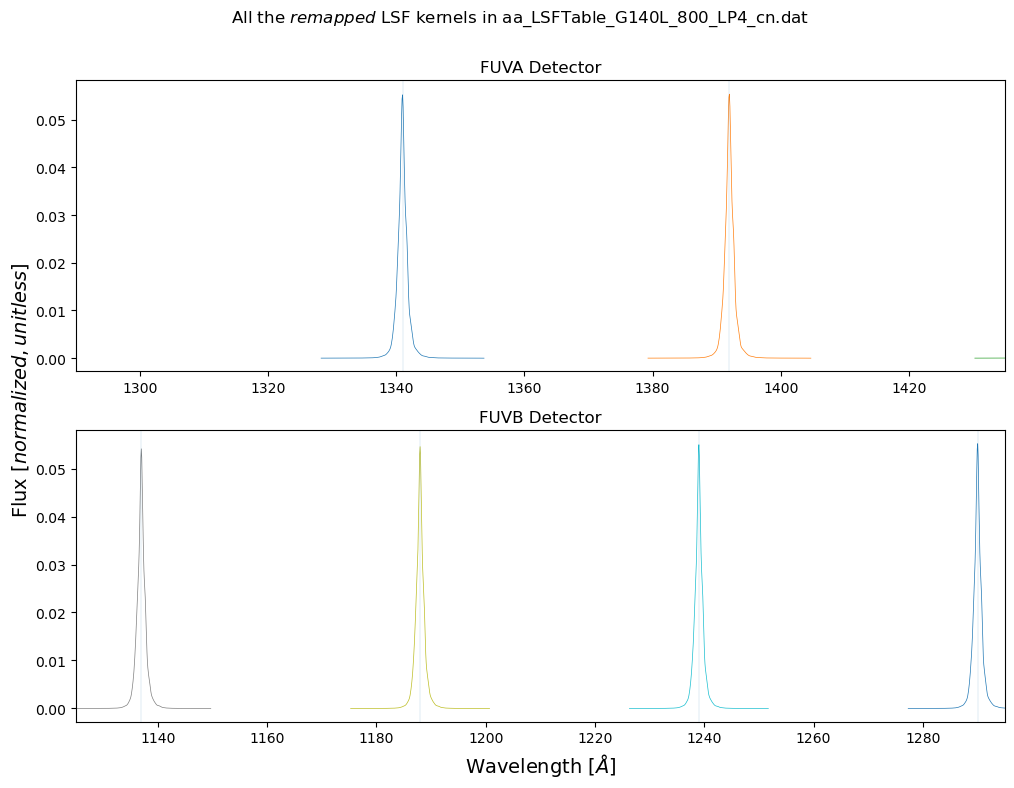

In [20]:
# Generate the redefined lsf for the plot
new_lsf, new_w, step = redefine_lsf(
    str(datadir / LSF_file_name),
    param_dict["CENWAVE"],
    str(datadir / param_dict["DISPTAB"]),
)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)

# Loop through the new remapped lsf kernels
for i, col in enumerate(new_w):
    line_wvln = int(col)  # central position
    contents = new_lsf[:, i]  # actual shape
    if line_wvln < 1291:  # split into the FUVB segment
        xrange = new_w[i] + pix * step  # ROUGHLY convert pix to wvln
        ax1.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax1.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line
    elif line_wvln > 1291:  # split into the FUVA segment
        xrange = new_w[i] + pix * step  # ROUGHLY convert pix to wvln
        ax0.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax0.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

# Add labels, titles and text
fig.suptitle(f"All the $remapped$ LSF kernels in {LSF_file_name}\n")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)

ax1.set_xlabel("Wavelength [$\AA$]", size=14)
fig.text(
    s="Flux [$normalized,unitless$]", x=-0.01, y=0.35, rotation="vertical", size=14
)

# format and save the figure
plt.tight_layout()
plt.savefig(str(plotsdir / "allKernels_new.png"), bbox_inches="tight")

#### Applying convolution

In [21]:
def convolve_lsf(wavelength, spec, cenwave, lsf_file, disptab, detector="FUV"):
    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.
    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    spec (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    detector (str) : Assumes an FUV detector, but you may specify 'NUV'.
    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get right format of LSF kernels
    new_lsf, new_w, step = redefine_lsf(lsf_file, cenwave, disptab, detector=detector)

    # sets up new wavelength scale used in the convolution
    nstep = round((max(wavelength) - min(wavelength)) / step) - 1
    wave_cos = min(wavelength) + np.arange(nstep) * step

    # resampling onto the input spectrum's wavelength scale
    interp_func = interp1d(wavelength, spec)  # builds up interpolated function from input spectrum
    spec_cos = interp_func(wave_cos)  # builds interpolated initial spectrum at COS' wavelength scale for convolution
    final_spec = interp_func(wave_cos)  # Initializes final spectrum to the interpolated input spectrum

    for i, w in enumerate(new_w):  # Loop through the redefined LSF kernels
        # First need to find the boundaries of each kernel's "jurisdiction": where it applies
        # The first and last elements need to be treated separately
        if i == 0:  # First kernel
            diff_wave_left = 500
            diff_wave_right = (new_w[i + 1] - w) / 2.0
        elif i == len(new_w) - 1:  # Last kernel
            diff_wave_right = 500
            diff_wave_left = (w - new_w[i - 1]) / 2.0
        else:  # All other kernels
            diff_wave_left = (w - new_w[i - 1]) / 2.0
            diff_wave_right = (new_w[i + 1] - w) / 2.0

        # splitting up the spectrum into slices around the redefined LSF kernel wvlns
        # will apply the kernel corresponding to that chunk to that region of the spectrum - its "jurisdiction"
        chunk = np.where(
            (wave_cos < w + diff_wave_right) & (wave_cos >= w - diff_wave_left)
        )[0]
        if len(chunk) == 0:
            # off the edge, go to the next chunk
            continue

        current_lsf = new_lsf[:, i]  # selects the current kernel

        if len(chunk) >= len(
            current_lsf
        ):  # Makes sure that the kernel is smaller than the chunk
            final_spec[chunk] = convolve(
                spec_cos[chunk],
                current_lsf,  # Applies the actual convolution
                boundary="extend",
                normalize_kernel=True,
            )

    return wave_cos, final_spec  # Remember, not the same length as input spectrum data!

#### Creating a box profile

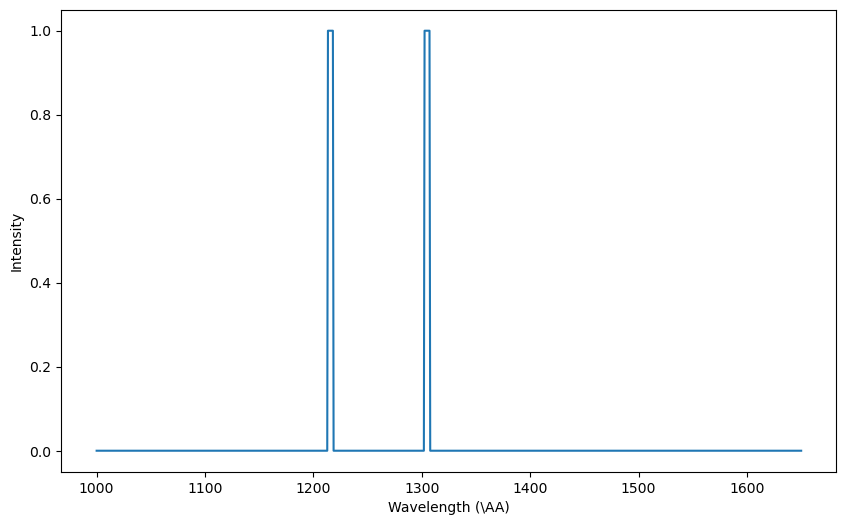

In [107]:
wavelength = np.linspace(1000, 1650, 1000) 
oi = 1305
lyalpha = 1216
width = 5.22 

box_profile = np.zeros_like(wavelength)
half_width = width / 2
box_profile[(wavelength >= (oi - half_width)) & (wavelength <= (oi + half_width))] = 1.0
box_profile[(wavelength >= (lyalpha - half_width)) & (wavelength <= (lyalpha + half_width))] = 1.0


plt.figure(figsize=(10,6))
plt.plot(wavelength, box_profile)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Intensity')
plt.show()


In [116]:
##### Generate data:
# Define a model spectral line with a Voigt profile
voigt_shape = functional_models.Voigt1D(
    x_0=1340, amplitude_L=1, fwhm_G=5.22/4, fwhm_L=5.22/4
)

# generate x data - Minimum size of Δ6Å for the kernel to apply here.
wvln_in = wavelength

spec_in = box_profile
#spec_in /= max(spec_in)  # Normalize the y data to a max of 1

##### Run the convolution
wvln_out, spec_out = convolve_lsf(
    wvln_in,
    spec_in,
    800,
    str(datadir+ LSF_file_name),
    str(datadir + param_dict["DISPTAB"]),
)

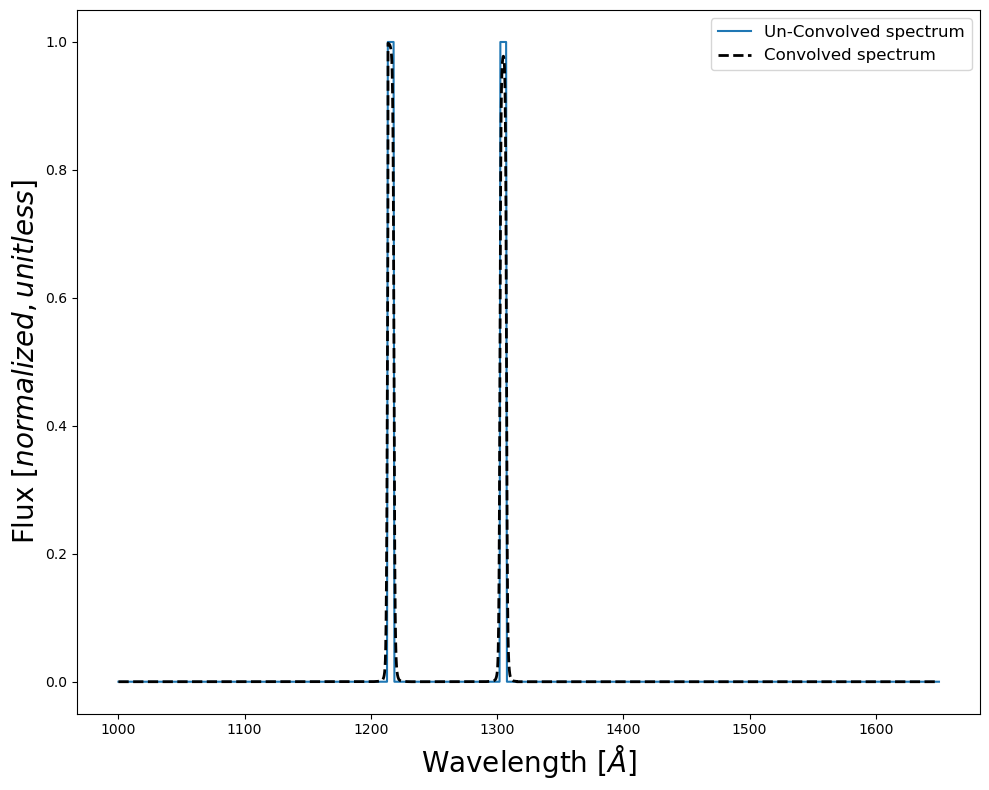

In [117]:
##### Make a plot from the data generated above:
plt.figure(figsize=(10, 8))  # Set up figure
# Plot the two spectra
plt.plot(wvln_in, spec_in, label="Un-Convolved spectrum")
plt.plot(
    wvln_out,spec_out,
    linestyle="--",linewidth=2,
    c="k",label="Convolved spectrum",
)

# Format and give fig the title and labels
plt.xlabel("Wavelength [$\AA$]", size=20)
plt.ylabel("Flux [$normalized,unitless$]", size=20)
# Add a legend
plt.legend(fontsize=12, loc="upper right")
#plt.xlim(1290, 1320)
# Save the figure
plt.tight_layout()
#plt.savefig(str(plotsdir / "applyConv1.png"), bbox_inches="tight")

# Multiply the profile by the inverse sensitivity function 

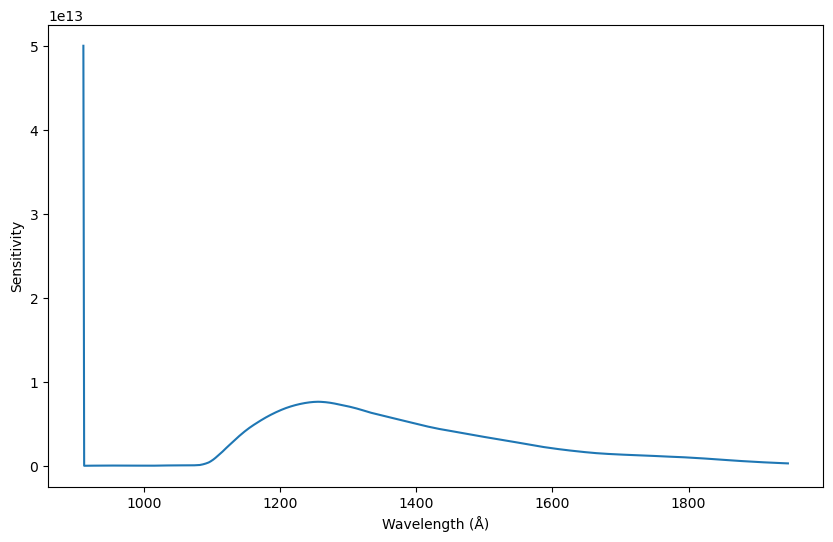

In [119]:
file_path = "C:/Users/serat/Downloads/AGN/data/manual/83j2044tl_phot.fits"


with fits.open(file_path) as fits_file:
    data = fits_file[1].data
    header = fits_file[1].header

## Row 50 is for FUVA, G140L, PSA, 800 (Our config)
wl= data[50][4]
sns = data[50][5]

plt.figure(figsize=(10, 6))
plt.plot(wl, sns)
plt.xlabel("Wavelength (Å)")  # Unit: Angstrom
plt.ylabel(r"Sensitivity")  # Unit: (count s–1 pixel–1)/(erg s–1 cm–2 Angstrom–1)
#plt.xlim(1290,1320)
plt.show()

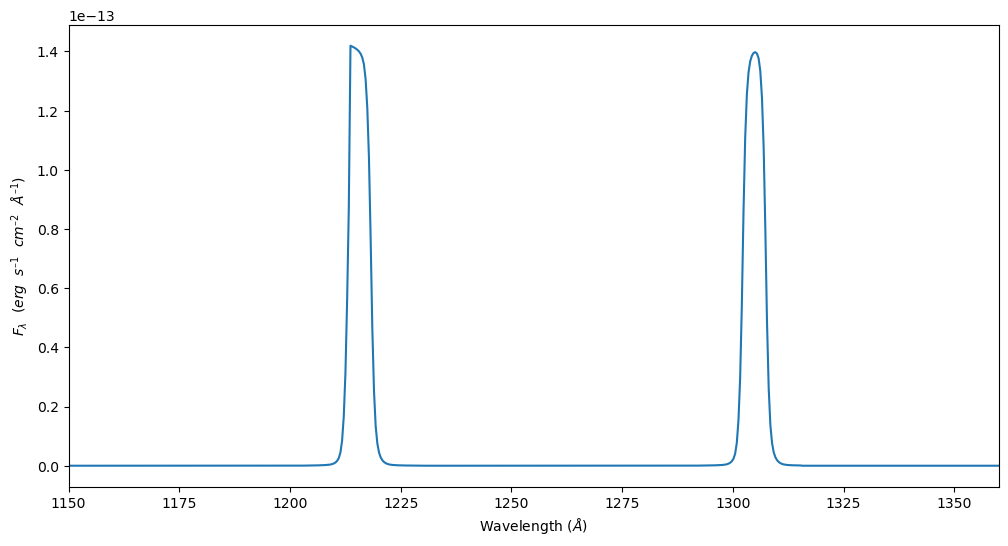

In [141]:
wl1 = wvln_out
flux1 = spec_out
wl2 = wl
flux2 = sns

interp_flux1 = interp1d(wl1, flux1, kind='linear', bounds_error=False, fill_value="extrapolate")
flux1_interp = interp_flux1(wl2)

combined_flux = (flux1_interp / flux2)

plt.figure(figsize=(12, 6))
#plt.plot(wl2, flux2, label='Sensitivity')
#plt.plot(wl2, flux1_interp, label='Interpolated Flux 1')
plt.plot(wl2, combined_flux, label='Combined Flux')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$F_{\lambda} \:\:\:(erg \:\:\: s^{–1} \:\:\: cm^{–2} \:\:\: \AA^{–1})$')
plt.xlim(1150,1360)
#plt.ylim(0.2,0.8e13)
plt.show()